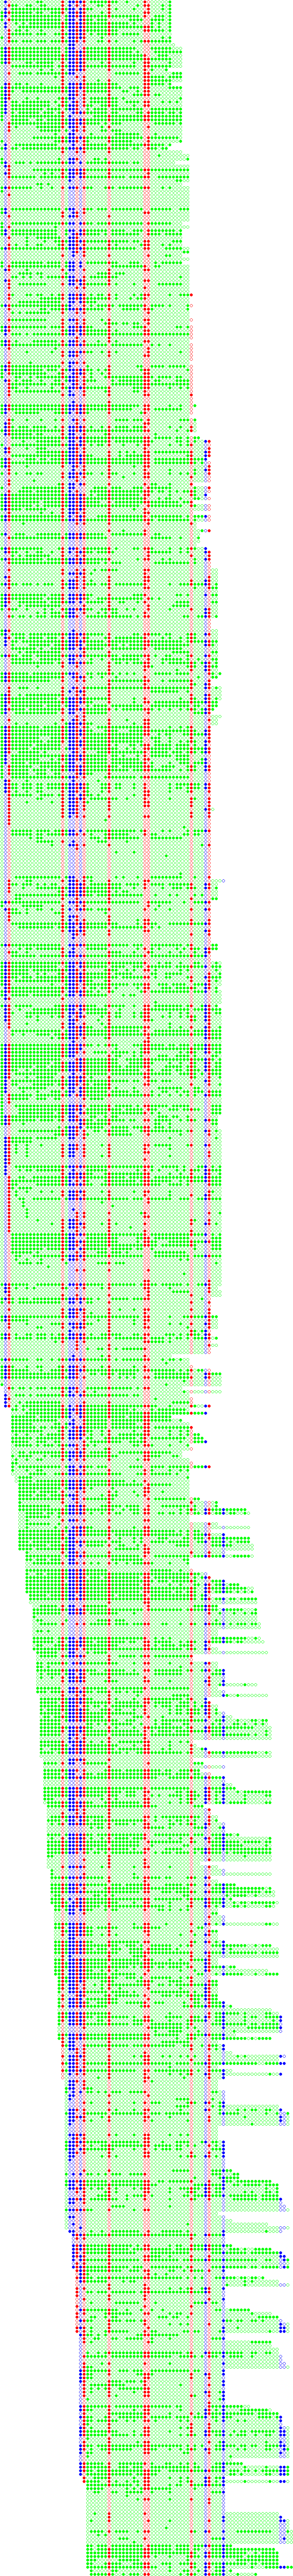

In [1]:
from IPython.display import Image
from PIL import Image
img = Image.open('ColT1EVD95.png') ## Opening image
img ## Displaying the image

In [2]:
#### Loading all libraries
from pathlib import Path
import glob
import os
from IPython.display import Image
from PIL import Image
import cv2
import numpy as np
import pandas as pd
dirt  =  %pwd
print(dirt) ## Current working directory
print("Tested - Correct directory, all modules/packages loaded, all functions created")
## Function used later for counting stretches in the next cell
## Must run this cell before running the next cell
def intersected(bottom_left1, top_right1, bottom_left2, top_right2):
    if top_right1[0] < bottom_left2[0] or bottom_left1[0] > top_right2[0]:
        return 0

    if top_right1[1] < bottom_left2[1] or bottom_left1[1] > top_right2[1]:
        return 0

    return 1

C:\Users\johnp\Downloads\Image_analysis\Counting
Tested - Correct directory, all modules/packages loaded, all functions created


In [3]:
%%time
input_file = "ColT1EVD95.png" ### Name of the image you want to quantify
analysis = "CNN" ### Change this to CHH if you only want to analyze CHH context stretches
only_name = os.path.splitext(os.path.basename(input_file))[0] ## It will take image name without ,png extension
directory = only_name  ## Folder name to store your data - It will be the name of your image
# Parent Directory path 
parent_dir = dirt
path = os.path.join(parent_dir, directory) # Path- combining your current directory with the folder name
new_path = os.mkdir(path) # Create the directory with your image name
limit = 721 ## This is the count of rows to be assessed.
if analysis == "CHH":
    targets_CHH = "Targets_CHH"
    path_targets_CHH = os.path.join(path, targets_CHH)
    os.mkdir(path_targets_CHH) ## Creating sub folder to store CHH targets
    img_initial = Image.open(input_file) ## Loading the initial imagae into jupyter notebook
    img_initial
    i=0
    j=12
    d = 1
    for x in range(1,limit+1):
        gray = img_initial.crop((0, i, 1250, j)) ## THis will crop or get one row each time
        targets = only_name +"/"+ "Targets_CHH"+"/"+ "row_%d.png"%d
        gray.save(targets) ## Saves
        i = i + 12
        j = j + 12
        d = d + 1
elif analysis == "CNN":
    targets_CNN = "Targets_CNN"
    path_targets_CNN = os.path.join(path, targets_CNN)
    os.mkdir(path_targets_CNN) ## Creating sub folder to store CNN targets
    m =  cv2.imread(input_file) ### Loading initial image for the conversion
    h,w,bpp = np.shape(m)
    for py in range(0,h):
        for px in range(0,w):
            if(m[py][px][1] <200):
                m[py][px][0]=0
                m[py][px][1]=255
                m[py][px][2]=0
                
    #cv2.imshow('matrix', m)
    print(path)
    #cv2. destroyAllWindows()
    ##cv2.waitKey(30)
    ##print(path)
    all_green = path+"/"+only_name+"_green.png" ## Saving converted image in your desired folder i.e., in image folder
    cv2.imwrite(all_green ,m)
    all_green = only_name+"/"+only_name+"_green.png"
    img_green = Image.open(all_green) ## Loading converted image into jupyter notebook
    img_green
    i=0
    j=12
    d = 1
    for x in range(1,limit+1):
        gray = img_green.crop((0, i, 1250, j)) ## This will crop or get one row each time
        targets = only_name +"/"+ "Targets_CNN"+"/"+ "row_%d.png"%d 
        gray.save(targets) ## Saves
        i = i + 12
        j = j + 12
        d = d + 1
else:
    print("Try CHH or CNN only")
print("Check that rows are saved in targets folder and input maximum non-empty row number in next cell - limit")

C:\Users\johnp\Downloads\Image_analysis\Counting\ColT1EVD95
Check that rows are saved in targets folder and input maximum non-empty row number in next cell - limit
Wall time: 19.1 s


In [4]:
%%time
if analysis == "CHH":
    import cv2
    import numpy as np
    count= []
    final_count = []
    result = []
    for i in range(48,0,-1): ## Number of templates are 48 i.e., running from 48 to 1 template
        for d in range(1,limit+1):
            filename = path+"/"+"Targets_CHH"+"/"+"row_%d.png"%d
            img_rgb = cv2.imread(filename)
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

            filename_template = "Templates/Templates_%i.png"%i
            template = cv2.imread(filename_template,0) ## Loading desired template
            w, h = template.shape[::-1]
            res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
            threshold = 0.999
            matches = []
            loc = np.where( res >= threshold)
            for pt in zip(*loc[::-1]):
                intersection = 0
                for match in matches:
                    if intersected(match, (match[0] + w, match[1] + h), pt, (pt[0] + w, pt[1] + h)):
                        intersection = 1
                        break
                if intersection == 0:
                    matches.append(pt)
                    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)
            filename_detected = only_name +"/"+ "Targets_CHH"+"/"+ "row_%d.png"%d ## Saving all detected images with stretches highlighted
            #     d = d+ 1
            cv2.imwrite(filename_detected,img_rgb)
            if len(matches) == 0:
    #             print(d,matches)
                count.append(0)
            else:
    #             print(d,i)
                ln = len(matches)
                count.append(i)
#         print(count)
        result.append(count)
        count = []
        
        

    pd.options.display.max_rows = 7000
    count = only_name +"/"+ only_name + "_count_CNN.txt"
    re = open(count,"a")
    final = pd.DataFrame.from_records(result)
    x=pd.DataFrame()
    x=final.max(axis = 0) 
    re.write(str(x))
    re.close() 
    read_file = pd.read_csv (count)
    os.remove(count)
    output_csv = 'count.csv'
    read_file.to_csv (output_csv, index=None)
    df = pd.read_csv(output_csv, header=None)
    os.remove(output_csv)
    df.columns = ['RowNumber' 'LongestStretch']
    df[['RowNumber', 'LongestStretch']] = df['RowNumberLongestStretch'].str.split(' ', n=1, expand=True)
    df = df.drop('RowNumberLongestStretch', 1)
    df['Genotype'] = only_name
    df.drop(df.tail(1).index,inplace=True)
    final_count = only_name +"/"+ only_name+"_count_CHH_R.txt"
    df.to_csv(final_count,index=False)
    df = pd.read_csv(final_count)
    os.remove(final_count)
    df.sort_values(by=['LongestStretch'], inplace=True)
    print(df)
    final_count = only_name +"/"+ only_name+"_count_CHH_R.txt" ## Final count file
    df.to_csv(final_count,index=False)

elif analysis == "CNN":
    import cv2
    import numpy as np
    count= []
    final_count = []
    result = []
    for i in range(47,0,-1):
        for d in range(1,limit+1):
            filename = path+"/"+"Targets_CNN"+"/"+"row_%d.png"%d
            img_rgb = cv2.imread(filename)
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

            filename_template = "Templates/Templates_%i.png"%i


            template = cv2.imread(filename_template,0) ## Loading desired template
            w, h = template.shape[::-1]
            res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
            threshold = 0.999
            matches = []
            loc = np.where( res >= threshold)
            for pt in zip(*loc[::-1]):
                intersection = 0
                for match in matches:
                    if intersected(match, (match[0] + w, match[1] + h), pt, (pt[0] + w, pt[1] + h)):
                        intersection = 1
                        break
                if intersection == 0:
                    matches.append(pt)
                    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)
            filename_detected = only_name +"/"+ "Targets_CNN"+"/"+ "row_%d.png"%d ## Saving all detected images with stretches highlighted
            #     d = d+ 1
            cv2.imwrite(filename_detected,img_rgb)
            if len(matches) == 0:
    #             print(d,matches)
                count.append(0)
            else:
    #             print(d,i)
                ln = len(matches)
                count.append(i)
#         print(count)
        result.append(count)

        count = []
    pd.options.display.max_rows = 7000
    count = only_name +"/"+ only_name + "_count_CNN.txt"
    re = open(count,"a")
    final = pd.DataFrame.from_records(result)
    x=pd.DataFrame()
    x=final.max(axis = 0) 
    re.write(str(x))
    re.close() 
    read_file = pd.read_csv (count)
    os.remove(count)
    output_csv = 'count.csv'
    read_file.to_csv (output_csv, index=None)
    df = pd.read_csv(output_csv, header=None)
    os.remove(output_csv)
    df.columns = ['RowNumber' 'LongestStretch']
    df[['RowNumber', 'LongestStretch']] = df['RowNumberLongestStretch'].str.split(' ', n=1, expand=True)
    df = df.drop('RowNumberLongestStretch', 1)
    df['Genotype'] = only_name
    df.drop(df.tail(1).index,inplace=True)
    final_count = only_name +"/"+ only_name+"_count_CNN_R.txt"
    df.to_csv(final_count,index=False)
    df = pd.read_csv(final_count)
    os.remove(final_count)
    df.sort_values(by=['LongestStretch'], inplace=True)
    print(df)
    final_count = only_name +"/"+ only_name+"_count_CNN_R.txt"
    df.to_csv(final_count,index=False)

   
                     
else:
    print("Try CHH or CNN only")
    
print("Analysis Done !!")
    

     RowNumber  LongestStretch    Genotype
165        165               0  ColT1EVD95
88          88               0  ColT1EVD95
627        627               0  ColT1EVD95
81          81               0  ColT1EVD95
240        240               0  ColT1EVD95
241        241               0  ColT1EVD95
151        151               0  ColT1EVD95
243        243               0  ColT1EVD95
621        621               0  ColT1EVD95
72          72               0  ColT1EVD95
263        263               0  ColT1EVD95
61          61               0  ColT1EVD95
268        268               0  ColT1EVD95
57          57               0  ColT1EVD95
56          56               0  ColT1EVD95
55          55               0  ColT1EVD95
656        656               0  ColT1EVD95
438        438               0  ColT1EVD95
619        619               0  ColT1EVD95
100        100               0  ColT1EVD95
455        455               0  ColT1EVD95
158        158               0  ColT1EVD95
147        